In [ ]:
"""
# 전처리 배분

1(성준) - 0~9,   40~49, 80~89, 120, 
       - credit_card_balance.csv
       - POS_CASH_balance.csv
       - previous_application.csv
       - installments_payments.csv
2(장호) - 10~19, 50~59, 90~99, 121
3(두영) - 20~29, 60~69, 100~109, 122, 
       - bureau.csv,
4(혜빈) - 30~39, 70~79, 110~119, 123, 
       - bureau_balance.csv
5(준혁) -  
"""

"""
# 데이터 목록
application_test.csv
application_train.csv
credit_card_balance.csv
POS_CASH_balance.csv
previous_application.csv
installments_payments.csv
bureau.csv
bureau_balance.csv
sample_submission.csv
"""

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import user_functions as uf

%matplotlib inline
# 한글 출력되게 설정
uf.korean2()

In [34]:
# Load file
train_datasets = pd.read_csv(uf.get_f_path()+"application_train.csv")
test_datasets = pd.read_csv(uf.get_f_path()+"application_test.csv")

# Label 만들기
train_target_ds = train_datasets[["SK_ID_CURR", "TARGET"]]

# TARGET feature 삭제
train_datasets.drop(columns="TARGET", inplace=True)

In [35]:
# # info
# print(train_datasets.info())
# print(test_datasets.info())

# # train은 307,511 행
# # test는   48,744 행
# # -----------------
# # 총      356,255 행

In [36]:
# train datasets과 test datasets을 구분하는 "train/test" feature 생성
train_datasets["train/test"] = "train"
test_datasets["train/test"] = "test"

# 합치기
train_test_datasets = pd.concat([train_datasets, test_datasets], ignore_index=True)

# 356,255 행인지 확인
train_test_datasets.info()

# index 재설정
# print(train_datasets.index)
# print(test_datasets.index)
train_test_datasets.reset_index(drop=True, inplace=True)
# print(train_test_datasets.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to train/test
dtypes: float64(65), int64(40), object(17)
memory usage: 331.6+ MB


In [37]:
# 전처리 데이터
prepro_ds = train_test_datasets.copy()

# 데이터 전처리 진행 및 특이사항
---

## "TARGET"
- 연체자가 적은 편향된 데이터
- value_counts()
- 1=연체
> ```python
> 0    282686
> 1     24825
> ```

<hr><br>

## "CODE_GENDER"
- 'M', 'F', 'XNA'
- 'XNA'는 결측치라기 보다는 간성 등으로 파악됨. 따라서 그대로 놔둠
- []숫자로 대치
- 성별
- value_counts()
> ```python
> F      202448
> M      105059
> XNA         4
> ```

<hr><br>

## "FLAG_OWN_CAR", "FLAG_OWN_REALTY"
- 'Y', 'N'
- [V]숫자로 대치

<hr><br>

## "CNT_CHILDREN"
- [V] 5명 이상인 값을 5 이상으로 처리
- value_counts()
> ```python
> 0     215371
> 1      61119
> 2      26749
> 3       3717
> 4        429
> 5         84
> 6         21
> 7          7
> 14         3
> 8          2
> 9          2
> 12         2
> 10         2
> 19         2
> 11         1
> ```

<hr><br>

## "AMT_INCOME_TOTAL"
- 117000000 값은 이상치로 판단됨. 대출액 대비 소득 수준을 볼 때 fatfinger로 판단됨
- [V] 117000000 / 10으로 대체함
- <span style="color:yellow">TODO: 편차가 크다고 판단되나, 우선 그대로 진행함</span>


<hr><br>

## "AMT_CREDIT"
- 큰 이상 없다고 판단됨
- <span style="color:yellow">TODO: 편차가 크다고 판단되나, 우선 그대로 진행함</span>

<hr><br>

## "AMT_ANNUITY", "AMT_GOODS_PRICE"
- 결측치를 대출금액을 기준으로 가장 유사한 값으로 대체함
- [V] 결측치 값을 `imput_other_f_mean` 함수를 활용해 대체함

<hr><br>

## "ORGANIZATION_TYPE"
- 무직자를 XNA로 처리함. 문제 없음
```python
prepro_ds.loc[prepro_ds["ORGANIZATION_TYPE"] == "XNA", ("NAME_INCOME_TYPE", "ORGANIZATION_TYPE")].value_counts()
```
> ```python
> NAME_INCOME_TYPE  ORGANIZATION_TYPE
> Pensioner         XNA                  55352
> Unemployed        XNA                     22
> ```

<hr><br>

## "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"
- 외부 자료 출처에 대한 정규화된 점수
- [V] NAN 값이 많으나, 외부 자료에 대한 신뢰성(가중치)를 의미하므로 0으로 처리함

<hr><br>

## 기타 1
#### "APARTMENTS_AVG" 
#### "BASEMENTAREA_AVG" 
#### "YEARS_BEGINEXPLUATATION_AVG" 
#### "YEARS_BUILD_AVG" 
#### "COMMONAREA_AVG"
#### "ELEVATORS_AVG"
- 정규화된 자료
- 아파트 평균, 지하 면적 평균, 개발 시작연도 평균, 건물 연령 평균, 공용 공간 평균, 엘리베이터 수 평균
- [V] NAN 값이 많으나, 해당 정보가 없는 데이터라고 판단하여 0으로 처리함

## "ENTRANCES_AVG"
- 정규화된 자료
- 출입구 수의 평균을 의미함
- 0도 361개 존재함
- 결측값이 상당히 많음 178,407
- [V] <span style="color:yellow">중앙값으로 대체함</span>

<hr><br>

## "FONDKAPREMONT_MODE"
- 뭘 뜻하는 feature인지 알 수 없음
- [V] 결측치를 'not specified'로 대체함.

<hr><br>

## "HOUSETYPE_MODE"
- 결측값 154297
- [V] HOUSE에 거주하지 않는다고 판단하고 XNA로 처리함
- 나머지 값 분포
```python
block of flats      150503
specific housing      1499
terraced house        1212
```
<!-- - <span style="color:red">TODO: 처리 여부 결정</span> -->

<hr><br>

## 기타 2
#### "FLOORSMIN_MEDI"
#### "LANDAREA_MEDI"
#### "LIVINGAPARTMENTS_MEDI"
#### "LIVINGAREA_MEDI"
#### "NONLIVINGAPARTMENTS_MEDI"
#### "NONLIVINGAREA_MEDI"
#### "TOTALAREA_MODE"

- [V] NAN 값이 많으나, 해당 정보가 없는 데이터라고 판단하여 0으로 처리함

<hr><br>

## "WALLSMATERIAL_MODE"

- na 180234개로 상당히 많음.
- 따로 구분하기 어렵다고 판단하여 others로 처리함
```python
Panel           77309
Stone, brick    75249
Block           10681
Wooden           6156
Mixed            2649
Monolithic       2068
Others           1909
```

<hr><br>

## "AMT_REQ_CREDIT_BUREAU_QRT"
- 대출 신청 90일~30일 전 고객에 대한 CB 문의 건수
- unique = [  0.  nan   1.   2.   4.   3.   8.   5.   6.   7. 261.  19.]
- 261과 19는 다른 데이터와 비교했을 때 비정상적임. 가장 큰 값인 8로 대체함.


In [38]:
##########################################################
######################## SUNGJUNE ########################
##########################################################
# 자녀가 5명 이상인 값을 5로 처리
prepro_ds.loc[prepro_ds["CNT_CHILDREN"] >= 5, "CNT_CHILDREN"] = 5

# 이상치 117000000에서 0을 하나 제거함
prepro_ds.loc[prepro_ds["AMT_INCOME_TOTAL"] > 1e+08, "AMT_INCOME_TOTAL"] = prepro_ds.loc[prepro_ds["AMT_INCOME_TOTAL"] > 1e+08, "AMT_INCOME_TOTAL"].map(lambda x: x / 10)

# "AMT_ANNUITY"를 "AMT_CREDIT"기준으로 가장 유사한 값을 통해 대체함
prepro_ds["AMT_ANNUITY"] = \
    uf.imput_other_f_mean(prepro_ds, "AMT_ANNUITY", "AMT_CREDIT")

# "AMT_GOODS_PRICE"를 "AMT_CREDIT"기준으로 가장 유사한 값을 통해 대체함
prepro_ds["AMT_GOODS_PRICE"] = \
    uf.imput_other_f_mean(prepro_ds, "AMT_GOODS_PRICE", "AMT_CREDIT")

# SimpleImputer 사용
# sp_input = SimpleImputer()
# prepro_ds["AMT_GOODS_PRICE"] = \
#     pd.DataFrame(sp_input.fit_transform(\
#         prepro_ds[["AMT_GOODS_PRICE", "AMT_CREDIT"]]
#         ,columns=["AMT_GOODS_PRICE", "AMT_CREDIT"]
#                                        )
#                 )["AMT_GOODS_PRICE"].hist()

# "EXT_SOURCE_1"의 결측치를 0으로 대체함
# 외부 자료의 신뢰성을 의미하는 자료이므로 외부 자료가 없는 것을 의미한다고 판단됨
prepro_ds["EXT_SOURCE_1"].fillna(0, inplace=True)
prepro_ds["EXT_SOURCE_2"].fillna(0, inplace=True)
prepro_ds["EXT_SOURCE_3"].fillna(0, inplace=True)
prepro_ds["FONDKAPREMONT_MODE"].fillna("not specified", inplace=True)

# 결측치를 0으로 대체함
zero_imputation_lists= ["FLOORSMIN_MEDI",
                        "LANDAREA_MEDI",
                        "LIVINGAPARTMENTS_MEDI",
                        "LIVINGAREA_MEDI",
                        "NONLIVINGAPARTMENTS_MEDI",
                        "NONLIVINGAREA_MEDI",
                        "TOTALAREA_MODE",
                        "APARTMENTS_AVG",
                        "BASEMENTAREA_AVG",
                        "YEARS_BEGINEXPLUATATION_AVG",
                        "YEARS_BUILD_AVG",
                        "COMMONAREA_AVG",
                        "ELEVATORS_AVG"]
for feature in zero_imputation_lists:
    prepro_ds.loc[:, feature].fillna(0, inplace=True)

# 중앙값으로 대체함
imput_mean = SimpleImputer(strategy="median")
prepro_ds["ENTRANCES_AVG"] = imput_mean.fit_transform(prepro_ds[["ENTRANCES_AVG"]])

# "WALLSMATERIAL_MODE" "Others"로 대체
prepro_ds["WALLSMATERIAL_MODE"].fillna("Others", inplace=True)

# 이상치를 정상값 범위 중 가장 큰 8로 대체함
prepro_ds["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(8, inplace=True)

# "HOUSETYPE_MODE" 결측치 "XNA"로 대체 ∵ HOUSE외 주거 시설에 거주한다고 판단.
prepro_ds["HOUSETYPE_MODE"].fillna("XNA", inplace=True)


In [39]:
##########################################################
######################### JANGHO #########################
##########################################################
# Null 처리
# prepro_ds['AMT_GOODS_PRICE'].fillna(prepro_ds['AMT_GOODS_PRICE'].mean(), inplace = True)
prepro_ds['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace = True)
prepro_ds['EMERGENCYSTATE_MODE'].fillna('No', inplace = True)
prepro_ds['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0, inplace = True)
prepro_ds.loc[:, "ENTRANCES_AVG":"BASEMENTAREA_MODE"] = \
    prepro_ds.loc[:, "ENTRANCES_AVG":"BASEMENTAREA_MODE"].fillna(0)
prepro_ds.loc[:, "EMERGENCYSTATE_MODE":"DAYS_LAST_PHONE_CHANGE"] = \
    prepro_ds.loc[:, "EMERGENCYSTATE_MODE":"DAYS_LAST_PHONE_CHANGE"].fillna(0)
prepro_ds.loc[:, "AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(0, inplace=True)

# IQR을 이용한 Outlier median 대체
def replace_outlier_by_med(feature):
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    
    mask = np.where((feature > upper_bound) | (feature < lower_bound),feature.median(), feature)
    return mask

prepro_ds['AMT_GOODS_PRICE'] = replace_outlier_by_med(prepro_ds['AMT_GOODS_PRICE'])

In [40]:
##########################################################
######################### HYEBIN #########################
##########################################################
prepro_ds.loc[:, "NONLIVINGAPARTMENTS_MODE":"FLOORSMAX_MEDI"] = \
    prepro_ds.loc[:, "NONLIVINGAPARTMENTS_MODE":"FLOORSMAX_MEDI"].fillna(0)
prepro_ds.loc[:, "AMT_REQ_CREDIT_BUREAU_HOUR":"AMT_REQ_CREDIT_BUREAU_MON"] = \
prepro_ds.loc[:, "AMT_REQ_CREDIT_BUREAU_HOUR":"AMT_REQ_CREDIT_BUREAU_MON"].fillna(0)

In [41]:
##########################################################
######################## DOOYOUNG ########################
##########################################################
prepro_ds["OWN_CAR_AGE"].fillna(-1, inplace=True)
prepro_ds.loc[:, "YEARS_BEGINEXPLUATATION_MODE":"LIVINGAREA_MODE"] = \
    prepro_ds.loc[:, "YEARS_BEGINEXPLUATATION_MODE":"LIVINGAREA_MODE"].fillna(0)
prepro_ds["OCCUPATION_TYPE"].fillna("Inoccupation", inplace=True)

prepro_ds.loc[prepro_ds["CNT_FAM_MEMBERS"] >= 8, "CNT_FAM_MEMBERS"] = 8
prepro_ds["CNT_FAM_MEMBERS"].fillna(1, inplace=True)

In [42]:
uf.check_missing_value(prepro_ds)

결측치 없음!


---
---

In [31]:
credit_card_ds = \
    pd.read_csv("../pre_data/new_credit_card_ds_balance.csv")
instal_pay_ds = \
    pd.read_csv("../pre_data/new_installments_payments.csv")
pos_cash_ds = \
    pd.read_csv("../pre_data/new_POS_CASH_balance.csv")
prev_app_ds = \
    pd.read_csv("../pre_data/new_previous_application.csv")
bureau_final = \
    pd.read_csv("../pre_data/bureau_final.csv")

In [32]:
# feature 중복 값 확인

colum_list = []
colum_list.append(list(credit_card_ds.columns))
colum_list.append(list(instal_pay_ds.columns))
colum_list.append(list(pos_cash_ds.columns))
colum_list.append(list(prev_app_ds.columns))
colum_list.append(list(prepro_ds.columns))
colum_list.append(list(bureau_final.columns))

col_list = []
for a in colum_list:
    for b in a:
        col_list.append(b)

pd.DataFrame(col_list).value_counts()#.unique()

NameError: name 'prepro_ds' is not defined

In [43]:
# feature name change
# credit_card_ds.rename(columns={"SK_DPD": "연체기간(credit_c)",
#                                "AMT_RECEIVABLE_PRINCIPAL": "미수원금",
#                                "소액연체_비율": "소액연체비중(credit_c)"},
#                       inplace=True
#                     )
pos_cash_ds.rename(columns={"SK_DPD": "연체기간(pos_cash)",
                            "소액연체_비율": "소액연체비중(pos_cash)"},
                   inplace=True
                  )
bureau_final.rename(columns={"AMT_ANNUITY": "AMT_ANNUITY(bure)"},
                    inplace=True
                   )

In [46]:
# # credit_card.csv의 경우 결측값이 252,697개에 달해 사용할 수 없다고 판단됨.
# merge_ds = pd.merge(prepro_ds, credit_card_ds, on="SK_ID_CURR", how="left")
# merge_ds = pd.merge(prepro_ds, prev_app_ds, on="SK_ID_CURR", how="left")
# merge_ds = pd.merge(merge_ds, instal_pay_ds, on="SK_ID_CURR", how="left")
# merge_ds = pd.merge(merge_ds, pos_cash_ds, on="SK_ID_CURR", how="left")
# merge_ds = pd.merge(merge_ds, bureau_final, on="SK_ID_CURR", how="left")

In [47]:
temp_ds = merge_ds[["train/test", "연체일"]]
temp_ds.loc[temp_ds["연체일"].isna()]["train/test"].value_counts()

train    33460
test      3486
Name: train/test, dtype: int64

In [48]:
uf.check_missing_value(merge_ds)

122        승인/거부(prev_app)                36,946
123            (추정)이자율                    36,946
124              연체일                      36,946
125             연체횟수                      36,946
126            승인액/요청액                    36,946
127           과거_상환액/총액                   16,671
128        연체기간(pos_cash)                 19,003
129       소액연체비중(pos_cash)                19,003
130       CREDIT_ACTIVE_idx               50,444
131        CREDIT_TYPE_idx                50,444
132      CREDIT_DAY_OVERDUE               50,444
133    AMT_CREDIT_MAX_OVERDUE             50,444
134        AMT_CREDIT_SUM                 50,444
135      AMT_CREDIT_SUM_DEBT              50,444
136    AMT_CREDIT_SUM_OVERDUE             50,444
137       AMT_ANNUITY(bure)               50,444
138        balance_STATUS                 50,444


In [ ]:
# ## credit 처리

# # "연체횟수"가 결측값이고, 연체 기간은 값이 있으면 연체 한 적이 있다고 판단하여 1 값 할당
# temp = merge_ds.loc[(merge_ds["연체횟수"].isna()) & \
#                     (merge_ds["연체기간(credit_c)"].notnull()), 
#                     ["연체횟수", "연체기간(credit_c)"]
#                    ]
# ## 연체기간이 0이면 연체횟수는 0
# temp.loc[temp["연체기간(credit_c)"] == 0, "연체횟수"] = 0
# ## 연체기간이 0이 아니면 연체횟수는 1
# temp.loc[temp["연체기간(credit_c)"] != 0, "연체횟수"] = 1
# temp.drop(columns="연체기간(credit_c)", inplace=True)
# merge_ds.loc[temp.index, "연체횟수"] = temp

# # "연체횟수"가 결측값이고, 연체 기간은 값이 있으면 연체 한 적이 있다고 판단하여 1 값 할당
# temp = merge_ds.loc[(merge_ds["연체횟수"].isna()) & \
#                     (merge_ds["연체기간(pos_cash)"].notnull()), 
#                     ["연체횟수", "연체기간(pos_cash)"]
#                    ]
# ## 연체기간이 0이면 연체횟수는 0
# temp.loc[temp["연체기간(pos_cash)"] == 0, "연체횟수"] = 0
# ## 연체기간이 0이 아니면 연체횟수는 1
# temp.loc[temp["연체기간(pos_cash)"] != 0, "연체횟수"] = 1
# temp.drop(columns="연체기간(pos_cash)", inplace=True)
# merge_ds.loc[temp.index, "연체횟수"] = temp

In [49]:
main_ds = merge_ds.copy()
main_ds.drop(columns="balance_STATUS", inplace=True)

<hr>
<hr>

In [50]:
# 승인/거부는 승인은 1 거부는 -1로하여 총 합한 값이기 때문에 - ~ + 사이의 값을 가짐
# uf.box_plot(main_ds, '승인/거부(prev_app)')

In [51]:
# features_list feature 다른 bureau_final 참고해서 대치
features_list = ["승인/거부(prev_app)", 
                 "(추정)이자율", 
                 "연체일", 
                 "연체횟수",
                 "연체기간(pos_cash)",
                 "소액연체비중(pos_cash)"
                ]

# CREDIT_DAY_OVERDUE(연체일)
for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["CREDIT_DAY_OVERDUE"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["CREDIT_DAY_OVERDUE"] == 0), 
                    feature].fillna(0)

for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                    feature].fillna(0)

################################################################

features_list = ["승인액/요청액", "과거_상환액/총액"]

for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["CREDIT_DAY_OVERDUE"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["CREDIT_DAY_OVERDUE"] == 0), 
                    feature].fillna(1)

for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                    feature].fillna(1)


"CREDIT_ACTIVE_idx" = 기존 대출 상태의 평균 (Closed, Active ... )/ 0은 낮은 위험도 / 1은 높은 위험도

"CREDIT_TYPE_idx" = 기존 대출 유형의 평균 / 0은 낮은 위험도 / 1은 높은 위험도

"CREDIT_DAY_OVERDUE" = 기존 대출 연체 일수의 평균 

"AMT_CREDIT_MAX_OVERDUE" = 기존 대출 연체 금액 중 최대값

"AMT_CREDIT_SUM" = 기존 대출 금액 누적 총액

"AMT_CREDIT_SUM_DEBT" = 기존 대출 중 미상환액 총액

"AMT_CREDIT_SUM_OVERDUE" = 기존 대출 연체액 총액 

"AMT_ANNUITY(bure)" = 기존 대출 월상환액의 총액

"balance_STATUS" = 연체 예측 / 높으면 위험  => <span style="color:red">결측치가 많음 Drop</span>

In [52]:
# bureau_final 결측치 다른 datasets 참고해서 대치

# if 연체일 = 0
#     => CREDIT_ACTIVE_idx = 0
#     => CREDIT_TYPE_idx = 0
#     => CREDIT_DAY_OVERDUE = 0
#     => AMT_CREDIT_MAX_OVERDUE = 0
#     => AMT_CREDIT_SUM = 0
#     => AMT_CREDIT_SUM_DEBT = 0
#     => AMT_CREDIT_SUM_OVERDUE = 0
#     => AMT_ANNUITY(bure) = 0

features_list = ["CREDIT_ACTIVE_idx", "CREDIT_TYPE_idx", "CREDIT_DAY_OVERDUE", 
                 "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY(bure)"]

for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체일"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체일"] == 0), 
                    feature].fillna(0)

for feature in features_list:
    main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                feature] = \
        main_ds.loc[(main_ds[feature].isna()) & (main_ds["연체기간(pos_cash)"] == 0), 
                    feature].fillna(0)


In [54]:
uf.check_missing_value(main_ds)

122        승인/거부(prev_app)                 3,564
123            (추정)이자율                     3,564
124              연체일                       3,564
125             연체횟수                       3,564
126            승인액/요청액                     3,564
127           과거_상환액/총액                    2,672
128        연체기간(pos_cash)                  3,214
129       소액연체비중(pos_cash)                 3,214
130       CREDIT_ACTIVE_idx                3,635
131        CREDIT_TYPE_idx                 3,635
132      CREDIT_DAY_OVERDUE                3,635
133    AMT_CREDIT_MAX_OVERDUE              3,635
134        AMT_CREDIT_SUM                  3,635
135      AMT_CREDIT_SUM_DEBT               3,635
136    AMT_CREDIT_SUM_OVERDUE              3,635
137       AMT_ANNUITY(bure)                3,635


In [57]:
# 결측행 제거

# temp = pd.merge(main_ds, train_target_ds, on="SK_ID_CURR", how="left")

# temp.loc[(temp["연체일"].isna()) |
#             (temp["연체기간(pos_cash)"].isna()) |
#             (temp["과거_상환액/총액"].isna()) |
#             (temp["CREDIT_ACTIVE_idx"].isna()) 
#             , "TARGET"].value_counts()
## 0.0    3307
## 1.0     360
## Name: TARGET, dtype: int64


main_ds.dropna(inplace=True)

# 태어난 날짜를 나이로 바꿈
main_ds["DAYS_BIRTH"] = main_ds["DAYS_BIRTH"].apply(lambda x: round(-x / 365, 0) + 1)

In [58]:
main_target_ds = \
    pd.merge(main_ds, train_target_ds, how="left", on="SK_ID_CURR")

In [59]:
# EXT_SOURCE feature importance가 높음
drop_f_list = [#"EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3",
               "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", 
               "DAYS_LAST_PHONE_CHANGE",
               "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", "LANDAREA_AVG","LIVINGAPARTMENTS_AVG", "LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "APARTMENTS_MODE", "BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE", "COMMONAREA_MODE","ELEVATORS_MODE", "ENTRANCES_MODE", "FLOORSMAX_MODE", "FLOORSMIN_MODE","LANDAREA_MODE", "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI", "YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI","COMMONAREA_MEDI", "ELEVATORS_MEDI", "ENTRANCES_MEDI","FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"]

main_target_ds.drop(columns=drop_f_list, inplace=True)

In [60]:
# 차원축소 1 - 개인 연락처 제공 동의 여부
temp_list = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
pca = PCA(n_components=1)
pca_1_list = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_CONT_MOBILE"]
pca_temp = pd.DataFrame(pca.fit_transform(main_target_ds[pca_1_list]), columns=["Contact"])
pca_ds = pd.concat([main_target_ds, pca_temp], axis=1)
pca_ds.drop(columns=temp_list, inplace=True)
print(pca.explained_variance_ratio_)


# 차원축소 2 - 실제 거주지와 일치 여부
temp_list = ["REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]
pca = PCA(n_components=1)
pca_2_list = ["REG_REGION_NOT_LIVE_REGION", "REG_CITY_NOT_LIVE_CITY"]
pca_temp = pd.DataFrame(pca.fit_transform(main_target_ds[pca_2_list]), columns=["거주지일치여부"])
pca_ds = pd.concat([pca_ds, pca_temp], axis=1)
pca_ds.drop(columns=temp_list, inplace=True)
print(pca.explained_variance_ratio_)


# 차원축소 3 - 지인 중 채무자 수
temp_list = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
pca = PCA(n_components=1)
pca_3_list = temp_list
pca_temp = pd.DataFrame(pca.fit_transform(main_target_ds[pca_3_list]), columns=["주변인채무"])
pca_ds = pd.concat([pca_ds, pca_temp], axis=1)
pca_ds.drop(columns=temp_list, inplace=True)
print(pca.explained_variance_ratio_)


# 차원축소 4 - 서류 제출 여부
temp_list = ["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"]
pca = PCA(n_components=1)
pca_4_list = ["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"]
pca_temp = pd.DataFrame(pca.fit_transform(main_target_ds[pca_4_list]), columns=["서류여부"])
pca_ds = pd.concat([pca_ds, pca_temp], axis=1)
pca_ds.drop(columns=temp_list, inplace=True)
print(pca.explained_variance_ratio_)


# 차원축소 5 - CB 문의 건수
temp_list = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
pca = PCA(n_components=1)
pca_5_list = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT"]
pca_temp = pd.DataFrame(pca.fit_transform(main_target_ds[pca_5_list]), columns=["CB문의"])
pca_ds = pd.concat([pca_ds, pca_temp], axis=1)
pca_ds.drop(columns=temp_list, inplace=True)
print(pca.explained_variance_ratio_)

[0.9880591]
[0.85137892]
[0.97758109]
[0.8187891]
[0.91122124]


In [78]:
# MZ세대 중 소득이 낮은 사람
# ~35
# <= 1.125000e+05(25%)

income_25q = pca_ds["AMT_INCOME_TOTAL"].quantile(0.25)
pool_ds = pca_ds.loc[(pca_ds["AMT_INCOME_TOTAL"] <= income_25q) & 
                     (pca_ds["DAYS_BIRTH"] <= 35)
                    ]

train_ds = pool_ds.loc[pool_ds["train/test"] == "train"].copy()
train_ds.drop(columns=["train/test"], inplace=True)

test_ds = pool_ds.loc[pool_ds["train/test"] == "test"].copy()
test_ds.drop(columns=["train/test"], inplace=True)
test_ds.drop(columns=["TARGET"], inplace=True)

train_ds.to_csv("../pre_data/[no_up]age35_income25q.csv")
# test_ds.to_csv("../pre_data/[no_up]age35_income25q.csv")

In [ ]:
encod_ds = pca_ds.copy()

# Label Encoding
encod_ds["NAME_CONTRACT_TYPE"] = \
    encod_ds["NAME_CONTRACT_TYPE"].factorize(["Cash loans", "Revolving loans"])[0]
encod_ds["FLAG_OWN_CAR"] = encod_ds["FLAG_OWN_CAR"].factorize(['N', 'Y'])[0]
encod_ds["FLAG_OWN_REALTY"] = encod_ds["FLAG_OWN_REALTY"].factorize(['N', 'Y'])[0]
encod_ds["NAME_EDUCATION_TYPE"] = \
     encod_ds["NAME_EDUCATION_TYPE"].factorize(["Lower secondary", "Secondary / secondary special", "Incomplete higher", "Higher education", "Academic degree"])[0]

# One Hot Encoding
encod_tt = encod_ds["train/test"]
encod_ds.drop(columns="train/test", inplace=True)
encod_ds = pd.get_dummies(encod_ds)

# 완전상관관계 제거 
encod_ds.drop(columns=["CODE_GENDER_XNA",
                       "NAME_TYPE_SUITE_Group of people",
                       "NAME_INCOME_TYPE_Maternity leave",
                       "NAME_HOUSING_TYPE_Co-op apartment",
                       "NAME_FAMILY_STATUS_Unknown",
                       "OCCUPATION_TYPE_IT staff",
                       "ORGANIZATION_TYPE_Industry: type 8"
                      ],
              inplace=True
              )

# 음수 값 양수로 변환
encod_ds[["DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] = \
    encod_ds[["DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]].apply(lambda x: -x)

# 근속연수 수정
encod_ds["DAYS_EMPLOYED"] = \
    encod_ds["DAYS_EMPLOYED"].apply(lambda x: (x / -365) if x < 0 else 0)

In [ ]:
train_ds = pca_ds.loc[pca_ds["train/test"] == "train"].copy()
train_ds.drop(columns=["train/test"], inplace=True)

test_ds = pca_ds.loc[pca_ds["train/test"] == "test"].copy()
test_ds.drop(columns=["train/test"], inplace=True)
test_ds.drop(columns=["TARGET"], inplace=True)

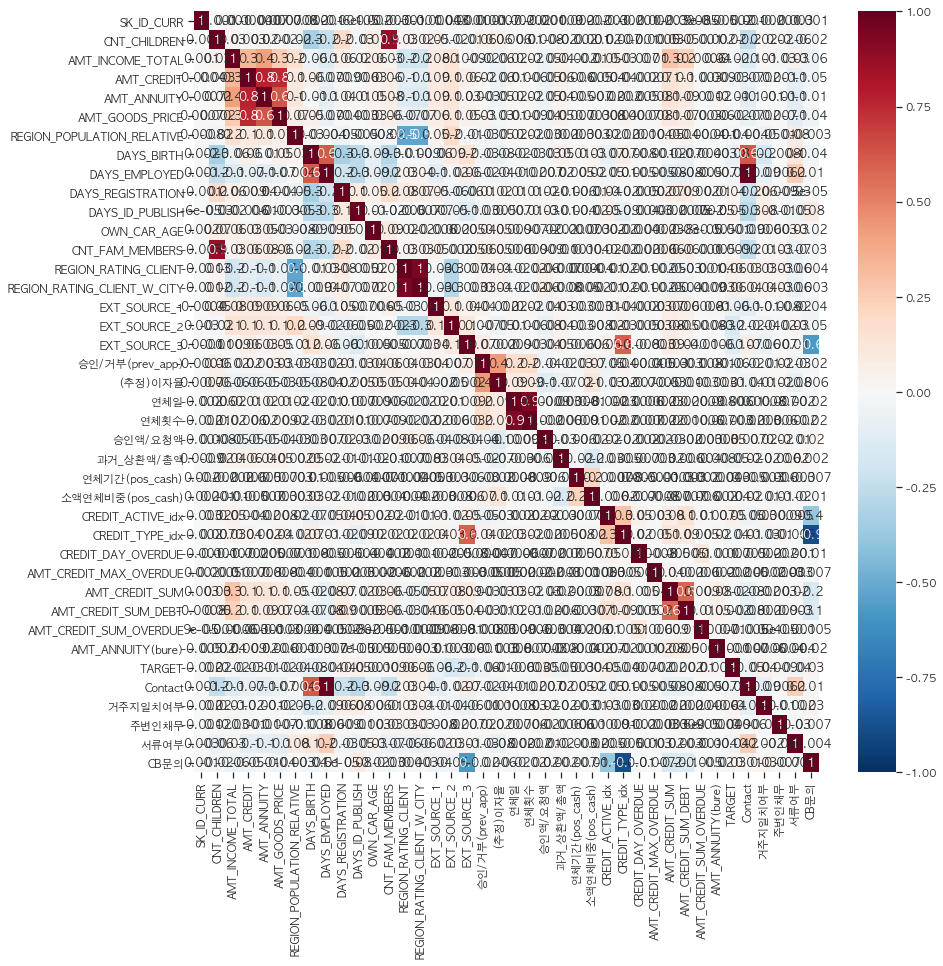

In [80]:
# def corr_heatmap(datasets):
#     corr = datasets.corr()
#     plt.figure(figsize=(14, 14))
#     sns.set_theme(style="ticks",
#                   font="AppleGothic", 
#                   rc={"axes.unicode_minus":False}
#                  )
#     sns.heatmap(corr, annot=True, fmt=".1g", vmin=-1, vmax=1, cmap="RdBu_r")

# corr_heatmap(pca_ds.loc[pca_ds["train/test"] == "train"])

In [ ]:
# 인코딩 X
# 스케일링 X
# 로그 X
train_ds.to_csv("../pre_data/[no_up]train_datasets(no_encod).csv")
test_ds.to_csv("../pre_data/[no_up]test_datasets(no_encod).csv")

In [ ]:
encod_ds = pd.concat([encod_ds, encod_tt], axis=1)
train_ds = encod_ds.loc[encod_ds["train/test"] == "train"].copy()
train_ds.drop(columns=["train/test"], inplace=True)

test_ds = encod_ds.loc[encod_ds["train/test"] == "test"].copy()
test_ds.drop(columns=["train/test"], inplace=True)
test_ds.drop(columns=["TARGET"], inplace=True)

In [ ]:
# 인코딩 O
# 스케일링 X
# 로그 X
train_ds.to_csv("../pre_data/[no_up]train_datasets.csv")
test_ds.to_csv("../pre_data/[no_up]test_datasets.csv")

In [ ]:
# 인코딩 O
# 스케일링 X
# 로그 O

log_f_list = ["AMT_INCOME_TOTAL", "AMT_ANNUITY", "OWN_CAR_AGE", "연체일", 
              "연체기간(pos_cash)", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY(bure)", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]

# log 변환
loged_ds = encod_ds.copy()
for feature in log_f_list:
    loged_ds[feature] = \
        loged_ds[feature].apply(lambda x: np.log1p(x) if x >= 0 else x)

In [ ]:
train_ds_log = loged_ds.loc[loged_ds["train/test"] == "train"].copy()
train_ds_log.drop(columns=["train/test"], inplace=True)

test_ds_log = loged_ds.loc[loged_ds["train/test"] == "test"].copy()
test_ds_log.drop(columns=["train/test"], inplace=True)
test_ds_log.drop(columns=["TARGET"], inplace=True)
train_ds_log.to_csv("../pre_data/[no_up]train_datasets(log).csv")
test_ds_log.to_csv("../pre_data/[no_up]test_datasets(log).csv")

In [ ]:
scaled_ds = loged_ds.copy()
scale_f_list = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", 
                "AMT_ANNUITY", "AMT_GOODS_PRICE","DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "OWN_CAR_AGE", "CNT_FAM_MEMBERS", "승인/거부(prev_app)", "연체일", "연체횟수", "연체기간(pos_cash)", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY(bure)"
               ]
for feature in scale_f_list:
    rbscaler = RobustScaler()
    # RobustScaler로 datasets 변환
    ds_rbscaler = rbscaler.fit_transform(scaled_ds[[feature]])
    # numpy.ndarray 반환된 값 pandas.DataFrame으로 변환
    scaled_ds[[feature]] = pd.DataFrame(ds_rbscaler, columns=[feature])

In [ ]:
train_ds_log_scale = scaled_ds.loc[scaled_ds["train/test"] == "train"].copy()
train_ds_log_scale.drop(columns=["train/test"], inplace=True)

test_ds_log_scale = scaled_ds.loc[scaled_ds["train/test"] == "test"].copy()
test_ds_log_scale.drop(columns=["train/test"], inplace=True)
test_ds_log_scale.drop(columns=["TARGET"], inplace=True)
train_ds_log_scale.to_csv("../pre_data/[no_up]train_datasets(log_scal).csv")
test_ds_log_scale.to_csv("../pre_data/[no_up]test_datasets(log_scal).csv")